In [2]:
import tensorflow as tf

print("tf version is ",tf.__version__)

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../lib/")
from pathlib import Path


2023-05-16 13:37:08.066682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 13:37:08.170781: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 13:37:08.171935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 13:37:09.308449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tf version is  2.13.0-dev20230411


In [3]:
dataset = "L_540_2022_C_E_R_B"
results_path = Path("../results/") / dataset
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))
if "file" in data.columns:
    X = data.drop(columns=["label", "file"])    
else:
    X = data.drop(columns=[""])

wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
#X = pd.get_dummies(df.drop(['label', 'file'], axis=1))
#Map the class names to integer values
#class_map = {'Both': 0, 'Control': 1, 'Etoposide': 2, 'Resveratrol': 3}
#y = df['label'] = df['label'].replace(class_map)

y = np.asarray(data.label)
y, y_key = pd.factorize(y) # not important but nice for enumerate below
y_one_hot = to_categorical(y)  # Perform one-hot encoding on the labels

for i, label in enumerate(y_key):
    print(f"{label}: {i}")
    
print("Shape of y_one_hot:", y_one_hot.shape)

Both: 0
Control: 1
Etoposide: 2
Resveratrol: 3
Shape of y_one_hot: (1200, 4)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

In [17]:
rate = 0.3
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(rate),
    Dense(4, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test), batch_size=32, verbose=False,
    use_multiprocessing = True,callbacks = [tf.keras.callbacks.EarlyStopping(patience=50)])

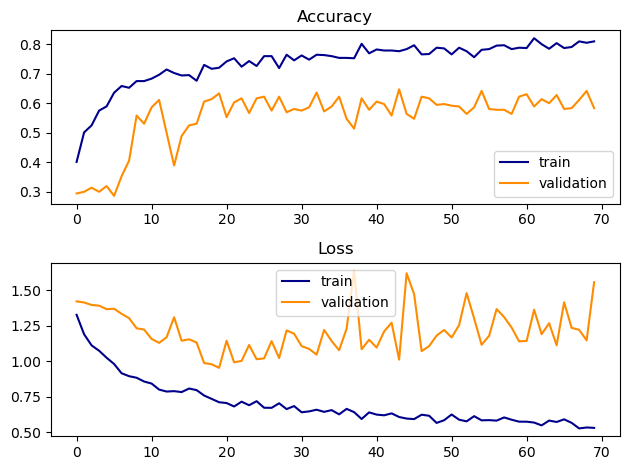

In [18]:
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="darkblue", label="train")
plt.plot(history.history["val_accuracy"], color="darkorange", label="validation")
plt.legend(loc="best")

plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(history.history["loss"], color="darkblue", label="train")
plt.plot(history.history["val_loss"], color="darkorange", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [19]:
y_pred = []
predictions = model.predict(X_test)  # Predict probabilities for all test samples
for prediction in predictions:
    y_hot_encoded = np.zeros_like(prediction)
    y_hot_encoded[np.argmax(prediction)] = 1
    y_pred.append(y_hot_encoded)

print("Model testing finished")


12/12 [==============================] - 0s 2ms/step
Model testing finished


In [20]:
# Convert one-hot encoded predictions to class indices
y_pred = np.argmax(y_pred, axis=1)
# Convert one-hot encoded true labels to class indices
y_test = np.argmax(y_test, axis=1)

In [21]:
# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
acc = accuracy_score(y_pred,y_test) # accuracy
cm = confusion_matrix(y_test,y_pred) # Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)

Accuracy: 0.5833333333333334
              precision    recall  f1-score   support

           0       0.81      0.53      0.64        94
           1       0.53      0.89      0.67        91
           2       0.65      0.49      0.56        92
           3       0.44      0.41      0.42        83

    accuracy                           0.58       360
   macro avg       0.61      0.58      0.57       360
weighted avg       0.61      0.58      0.58       360



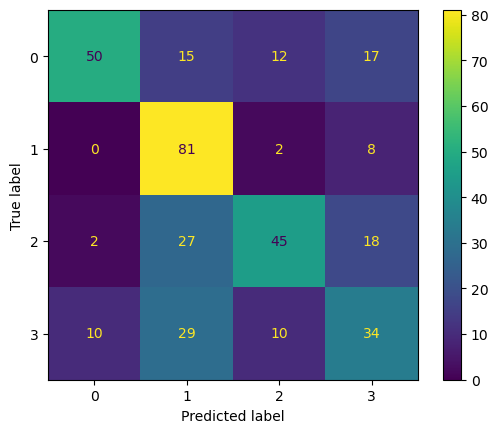

In [22]:
# Demo the evaluation
print('Accuracy:',acc)
print(classification_report(y_test,y_pred)) # Precision/Recall/F1-Score
cm_display.plot()
plt.show()

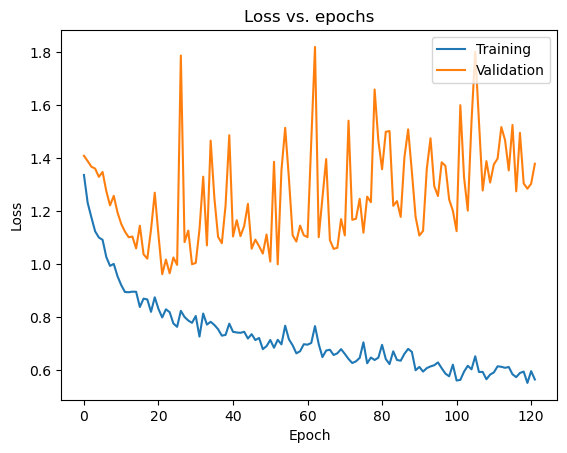

In [182]:
# Plot the training and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [183]:
# Evaluate the model on the test set

model.evaluate(X_test, y_test, verbose=2)

ValueError: in user code:

    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1964, in test_function  *
        return step_function(self, iterator)
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1948, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1936, in run_step  **
        outputs = model.test_step(data)
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1846, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1131, in compute_loss
        return self.compiled_loss(
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


In [12]:
# Continue with model training using the augmented data
model.fit(X_train_augmented, y_train_augmented, epochs=30, validation_data=(X_test, y_test), verbose = False, use_multiprocessing = True,
)

Epoch 1/30
578/578 - 3s - loss: 1.2120 - accuracy: 0.4409 - val_loss: 1.0037 - val_accuracy: 0.5889 - 3s/epoch - 6ms/step
Epoch 2/30
578/578 - 2s - loss: 0.9886 - accuracy: 0.5756 - val_loss: 0.9428 - val_accuracy: 0.6083 - 2s/epoch - 3ms/step
Epoch 3/30
578/578 - 2s - loss: 0.8857 - accuracy: 0.6252 - val_loss: 0.9092 - val_accuracy: 0.6361 - 2s/epoch - 3ms/step
Epoch 4/30
578/578 - 2s - loss: 0.8121 - accuracy: 0.6578 - val_loss: 0.9008 - val_accuracy: 0.6278 - 2s/epoch - 3ms/step
Epoch 5/30
578/578 - 2s - loss: 0.7389 - accuracy: 0.7035 - val_loss: 0.9011 - val_accuracy: 0.6417 - 2s/epoch - 3ms/step
Epoch 6/30
578/578 - 2s - loss: 0.6864 - accuracy: 0.7214 - val_loss: 0.8990 - val_accuracy: 0.6417 - 2s/epoch - 3ms/step
Epoch 7/30
578/578 - 2s - loss: 0.6263 - accuracy: 0.7500 - val_loss: 0.8857 - val_accuracy: 0.6111 - 2s/epoch - 3ms/step
Epoch 8/30
578/578 - 2s - loss: 0.5803 - accuracy: 0.7669 - val_loss: 0.9120 - val_accuracy: 0.6167 - 2s/epoch - 3ms/step
Epoch 9/30
578/578 - 2s 

In [9]:
# Define the augmentation parameters
num_augmentations = 20 #Number of augmented spectra to generate
shift_range = (-10, 10)  # Range for shifting the wavenumbers
intensity_factor_range = (0.8, 1.2)  # Range for scaling the intensities
noise_std = 0.05  # Standard deviation for adding random Gaussian noise

# Augment the spectral data
augmented_X_train = []
augmented_y_train = []

for spectrum, label in zip(X_train, y_train):
    for _ in range(num_augmentations):
        # Shift the wavenumbers
        shift_amount = np.random.uniform(*shift_range)
        shifted_spectrum = np.roll(spectrum, int(shift_amount))

        # Scale the intensities
        intensity_factor = np.random.uniform(*intensity_factor_range)
        scaled_spectrum = shifted_spectrum * intensity_factor

        # Add random Gaussian noise to the intensities
        noisy_spectrum = scaled_spectrum + np.random.normal(0, noise_std, spectrum.shape)

        augmented_X_train.append(noisy_spectrum)
        augmented_y_train.append(label)

# Convert the augmented data to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Combine the augmented data with the original data
combined_X_train = np.concatenate((X_train, augmented_X_train), axis=0)
combined_y_train = np.concatenate((y_train, augmented_y_train), axis=0)

# Shuffle the data
indices = np.arange(combined_X_train.shape[0])
np.random.shuffle(indices)
combined_X_train = combined_X_train[indices]
combined_y_train = combined_y_train[indices]

# Convert the augmented data to numpy arrays
augmented_X_train = np.array(combined_X_train)
augmented_y_train = np.array(combined_y_train)

# Concatenate the augmented data with the original data
X_train_augmented = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_y_train), axis=0)

array([[ 0.03139368,  0.03162657,  0.03145142, ...,  0.01035927,
         0.01027357,  0.01013634],
       [ 0.05222327,  0.05346469,  0.05411564, ...,  0.00703615,
         0.00664865,  0.00597674],
       [ 0.01848307,  0.01787108,  0.01725627, ...,  0.01167538,
         0.01151107,  0.01128769],
       ...,
       [ 0.04281138, -0.01255956,  0.11752682, ..., -0.0019891 ,
        -0.06721643, -0.02262205],
       [-0.06311008,  0.09149624,  0.07057034, ...,  0.03591744,
        -0.02924499,  0.00684625],
       [ 0.07272561, -0.06400477,  0.00591392, ..., -0.00573298,
        -0.1243598 ,  0.02611213]])

1/1 [==============================] - 0s 26ms/step


In [ ]:
%%bash 
pwd

In [ ]:
#%lsmagic

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/model_training_logs